In [2]:
# import functions, forecast and data

import csep
from csep.core import regions, catalog_evaluations
from csep.utils import datasets, time_utils
start_time = time_utils.strptime_to_utc_datetime("1992-06-28 11:57:35.0")
end_time = time_utils.strptime_to_utc_datetime("1992-07-28 11:57:35.0")

min_mw = 4.95
max_mw = 8.95
dmw = 0.1

# Create space and magnitude regions. The forecast is already filtered in space and magnitude
magnitudes = regions.magnitude_bins(min_mw, max_mw, dmw)
region = regions.california_relm_region()

# Bind region information to the forecast (this will be used for binning of the catalogs)
space_magnitude_region = regions.create_space_magnitude_region(region, magnitudes)

forecast = csep.load_catalog_forecast(datasets.ucerf3_ascii_format_landers_fname,
                                      start_time = start_time, end_time = end_time,
                                      region = space_magnitude_region,
                                      apply_filters = True)

# Assign filters to forecast
forecast.filters = [f'origin_time >= {forecast.start_epoch}', f'origin_time < {forecast.end_epoch}']

# Obtain Comcat catalog and filter to region.
comcat_catalog = csep.query_comcat(start_time, end_time, min_magnitude=forecast.min_magnitude)

# Filter observed catalog using the same region as the forecast
comcat_catalog = comcat_catalog.filter_spatial(forecast.region)

Fetched ComCat catalog in 1.0372536182403564 seconds.

Downloaded catalog from ComCat with following parameters
Start Date: 1992-06-28 12:00:45+00:00
End Date: 1992-07-24 18:14:36.250000+00:00
Min Latitude: 33.901 and Max Latitude: 36.705
Min Longitude: -118.067 and Max Longitude: -116.285
Min Magnitude: 4.95
Found 19 events in the ComCat catalog.


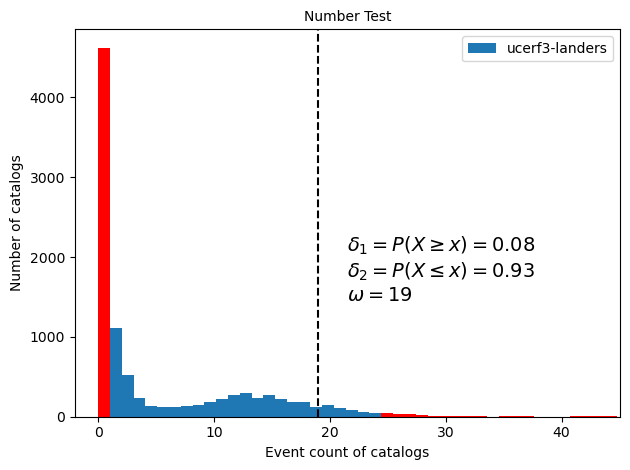

<Axes: title={'center': 'Number Test'}, xlabel='Event count of catalogs', ylabel='Number of catalogs'>

In [116]:
number_test_result = catalog_evaluations.number_test(forecast, comcat_catalog, verbose = False)
number_test_result.plot(show=True)

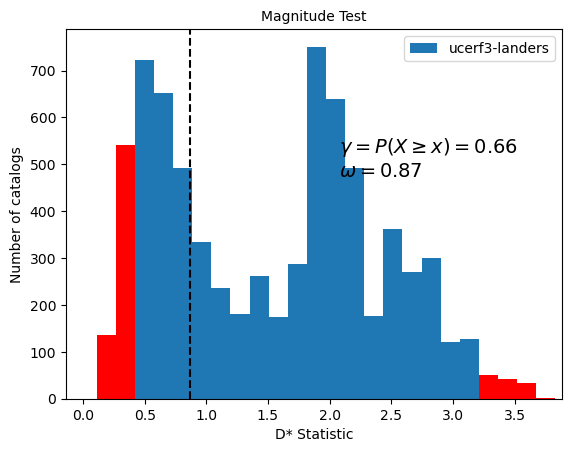

<Axes: title={'center': 'Magnitude Test'}, xlabel='D* Statistic', ylabel='Number of catalogs'>

In [117]:
standard_mag_test = catalog_evaluations.magnitude_test(forecast, comcat_catalog, verbose = False)
standard_mag_test.plot(show = True)

In [26]:
# import standard M-test function - this is just to check if it works in order to modify it later on
from csep.utils.stats import *
from csep.models import (
    CatalogNumberTestResult,
    CatalogSpatialTestResult,
    CatalogMagnitudeTestResult,
    CatalogPseudolikelihoodTestResult,
    CalibrationTestResult
)

def magnitude_test2(forecast, observed_catalog, verbose=True):
    """ Performs magnitude test for catalog-based forecasts """
    test_distribution = []

    if forecast.region.magnitudes is None:
        raise CSEPEvaluationException("Forecast must have region.magnitudes member to perform magnitude test.")

    # short-circuit if zero events
    if observed_catalog.event_count == 0:
        print("Cannot perform magnitude test when observed event count is zero.")
        # prepare result
        result = CatalogMagnitudeTestResult(test_distribution=test_distribution,
                                            name='M-Test',
                                            observed_statistic=None,
                                            quantile=(None, None),
                                            status='not-valid',
                                            min_mw=forecast.min_magnitude,
                                            obs_catalog_repr=str(observed_catalog),
                                            obs_name=observed_catalog.name,
                                            sim_name=forecast.name)

        return result

    # compute expected rates for forecast if needed
    if forecast.expected_rates is None:
        forecast.get_expected_rates(verbose=verbose)

    # returns the average events in the magnitude bins
    union_histogram = forecast.expected_rates.magnitude_counts()
    n_union_events = numpy.sum(union_histogram)
    obs_histogram = observed_catalog.magnitude_counts()
    n_obs = numpy.sum(obs_histogram)
    union_scale = n_obs / n_union_events
    scaled_union_histogram = union_histogram * union_scale

    # compute the test statistic for each catalog
    t0 = time.time()
    for i, catalog in enumerate(forecast):
        mag_counts = catalog.magnitude_counts()
        n_events = numpy.sum(mag_counts)
        if n_events == 0:
            # print("Skipping to next because catalog contained zero events.")
            continue
        scale = n_obs / n_events
        catalog_histogram = mag_counts * scale
        # compute magnitude test statistic for the catalog
        test_distribution.append(
            numpy.sum(numpy.square(numpy.log10(catalog_histogram + 1) - numpy.log10(scaled_union_histogram + 1)))
        )
        # output status
        if verbose:
            tens_exp = numpy.floor(numpy.log10(i + 1))
            if (i + 1) % 10 ** tens_exp == 0:
                t1 = time.time()
                print(f'Processed {i + 1} catalogs in {t1 - t0} seconds', flush=True)

    # compute observed statistic
    obs_d_statistic = numpy.sum(numpy.square(numpy.log10(obs_histogram + 1) - numpy.log10(scaled_union_histogram + 1)))

    # score evaluation
    delta_1, delta_2 = get_quantiles(test_distribution, obs_d_statistic)

    # prepare result
    result = CatalogMagnitudeTestResult(test_distribution=test_distribution,
                              name='M-Test',
                              observed_statistic=obs_d_statistic,
                              quantile=(delta_1, delta_2),
                              status='normal',
                              min_mw=forecast.min_magnitude,
                              obs_catalog_repr=str(observed_catalog),
                              obs_name=observed_catalog.name,
                              sim_name=forecast.name)

    return result

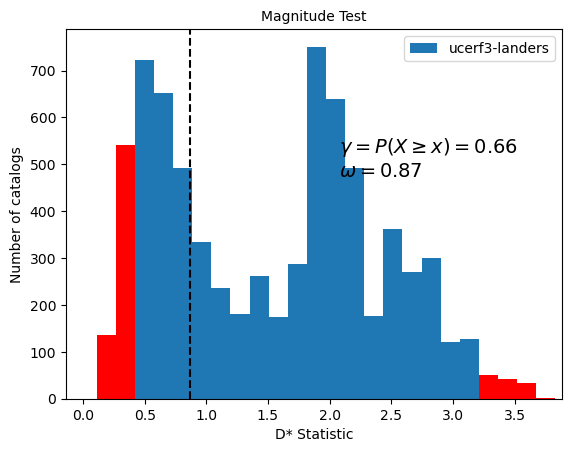

<Axes: title={'center': 'Magnitude Test'}, xlabel='D* Statistic', ylabel='Number of catalogs'>

In [118]:
standard_mag_test_2 = magnitude_test2(forecast, comcat_catalog, verbose = False)
standard_mag_test_2.plot(show = True)

In [119]:
# HERE THERE IS THE NEW FUNCTION
# NEW LINES ARE MARKED WITH "this is new"
# modification regards - introduction of random seed to reproduce random sampling
#                      - modification on how the histogram of the union forecast is calculated (for loop over catalogues)
#                      - use resampled catalogue instead of actual ones 

from csep.utils.stats import *
from csep.models import (
    CatalogNumberTestResult,
    CatalogSpatialTestResult,
    CatalogMagnitudeTestResult,
    CatalogPseudolikelihoodTestResult,
    CalibrationTestResult
)
import random
def magnitude_test_resampled(forecast, observed_catalog, verbose=True, mag_half_bin = 0.05,
                            rand_seed = 1):
    # set seed
    numpy.random.seed(rand_seed)
    """ Performs magnitude test for catalog-based forecasts """
    test_distribution = []
    
    if forecast.region.magnitudes is None:
        raise CSEPEvaluationException("Forecast must have region.magnitudes member to perform magnitude test.")

    # short-circuit if zero events
    if observed_catalog.event_count == 0:
        print("Cannot perform magnitude test when observed event count is zero.")
        # prepare result
        result = CatalogMagnitudeTestResult(test_distribution=test_distribution,
                                            name='M-Test',
                                            observed_statistic=None,
                                            quantile=(None, None),
                                            status='not-valid',
                                            min_mw=forecast.min_magnitude,
                                            obs_catalog_repr=str(observed_catalog),
                                            obs_name=observed_catalog.name,
                                            sim_name=forecast.name)

        return result

    # compute expected rates for forecast if needed
    if forecast.expected_rates is None:
        forecast.get_expected_rates(verbose=verbose)

    # this is new - returns the average events in the magnitude bins
    union_histogram = numpy.zeros(len(forecast.magnitudes))
    for j, cat in enumerate(forecast) :
        union_histogram += cat.magnitude_counts()
    # end new 
    n_union_events = numpy.sum(union_histogram)
    obs_histogram = observed_catalog.magnitude_counts()
    n_obs = numpy.sum(obs_histogram)
    union_scale = n_obs / n_union_events
    scaled_union_histogram = union_histogram * union_scale

    # this is new - prob to be used for resampling
    probs = union_histogram/n_union_events 
    # end new
    
    # compute the test statistic for each catalog
    t0 = time.time()
    for i, catalog in enumerate(forecast):
        # this is new - sampled from the union forecast histogram
        mag_values = numpy.random.choice(forecast.magnitudes + mag_half_bin, p = probs, size = int(n_obs))
        extended_mag_max = max(forecast.magnitudes) + 10
        mag_counts, tmp = numpy.histogram(mag_values, bins = numpy.append(forecast.magnitudes, extended_mag_max))
        # end new
        n_events = numpy.sum(mag_counts)
        if n_events == 0:
            # print("Skipping to next because catalog contained zero events.")
            continue
        scale = n_obs / n_events
        catalog_histogram = mag_counts * scale
        # compute magnitude test statistic for the catalog
        test_distribution.append(
            cumulative_square_diff(numpy.log10(catalog_histogram + 1), numpy.log10(scaled_union_histogram + 1))
        )
        # output status
        if verbose:
            tens_exp = numpy.floor(numpy.log10(i + 1))
            if (i + 1) % 10 ** tens_exp == 0:
                t1 = time.time()
                print(f'Processed {i + 1} catalogs in {t1 - t0} seconds', flush=True)

    # compute observed statistic
    obs_d_statistic = cumulative_square_diff(numpy.log10(obs_histogram + 1), numpy.log10(scaled_union_histogram + 1))

    # score evaluation
    delta_1, delta_2 = get_quantiles(test_distribution, obs_d_statistic)

    # prepare result
    result = CatalogMagnitudeTestResult(test_distribution=test_distribution,
                              name='M-Test',
                              observed_statistic=obs_d_statistic,
                              quantile=(delta_1, delta_2),
                              status='normal',
                              min_mw=forecast.min_magnitude,
                              obs_catalog_repr=str(observed_catalog),
                              obs_name=observed_catalog.name,
                              sim_name=forecast.name)

    return result


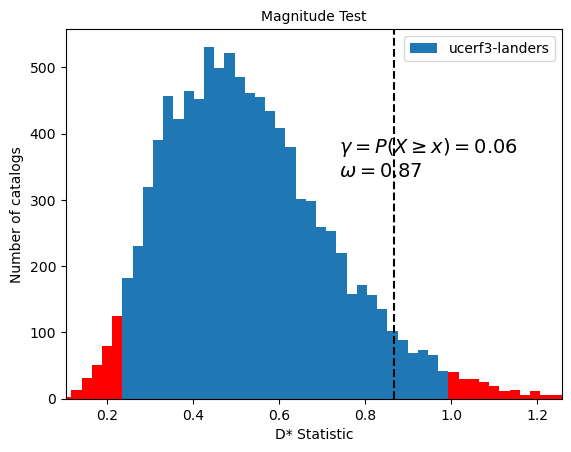

<Axes: title={'center': 'Magnitude Test'}, xlabel='D* Statistic', ylabel='Number of catalogs'>

In [120]:
mtest_resampled1 = magnitude_test_resampled(forecast, comcat_catalog, verbose = False, rand_seed = 1)
mtest_resampled1.plot(show = True)
# clear that the resampling produce much nicer statistics distributions 

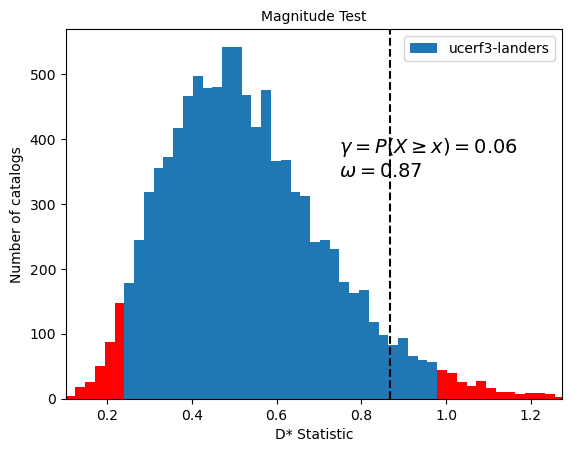

<Axes: title={'center': 'Magnitude Test'}, xlabel='D* Statistic', ylabel='Number of catalogs'>

In [121]:
mtest_resampled2 = magnitude_test_resampled(forecast, comcat_catalog, rand_seed=10, verbose = False)
mtest_resampled2.plot(show = True)
# slightly different cause of different seed but same qualitatively

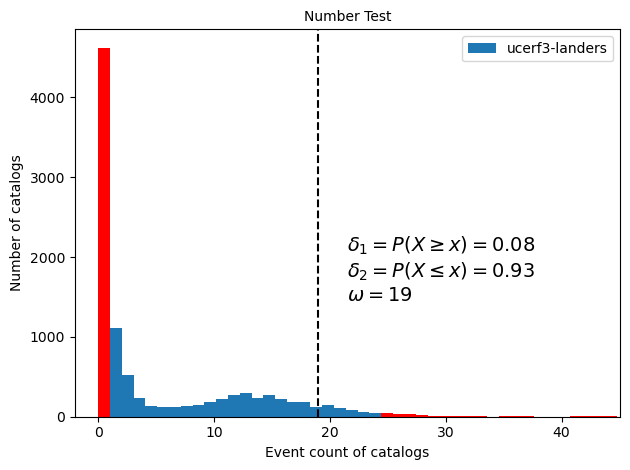

<Axes: title={'center': 'Number Test'}, xlabel='Event count of catalogs', ylabel='Number of catalogs'>

In [122]:
# the distribution of the test statistics without resampling looks weird because the distribution of the number of points is weird.
# it makes sense that the Dstatistic distribution is shifted to the right because many catalogs underestimate the number of events
# and this leads to higher values of the statistics. The effect disappear with resampling and we are on the other side of the distribution.
# the resampling correction removes this effect and we have a nice, bell-shaped distribution
ntest = catalog_evaluations.number_test(forecast, comcat_catalog, verbose = False)
ntest.plot(show = True)

In [23]:
from typing import Optional, TYPE_CHECKING
import time
# Third-Party Imports
import numpy
# PyCSEP imports
from csep.core.exceptions import CSEPEvaluationException
from csep.core.catalogs import CSEPCatalog
from csep.models import (
    CatalogMagnitudeTestResult
)
from csep.utils.stats import get_quantiles
def Chisquared_score(union_catalog_counts: numpy.ndarray, catalog_counts: numpy.ndarray):
    """
  
    """

    N_u = numpy.sum(union_catalog_counts)
    N_j = numpy.sum(catalog_counts)
    
    theoretical_counts = N_j*(union_catalog_counts/N_u)
    idx_nonzero = theoretical_counts > 0
    theoretical_counts = theoretical_counts[idx_nonzero]
    catalog_counts = catalog_counts[idx_nonzero]
    return numpy.mean( (theoretical_counts - catalog_counts)**2 / theoretical_counts )



def Chisquared_magnitude_test(forecast: "CatalogForecast",
                              observed_catalog: CSEPCatalog,
                              full_calculation: bool = False,
                              verbose: bool = False,
                              seed: Optional[int] = None) -> CatalogMagnitudeTestResult:
    """
    

    Args:
        forecast (CatalogForecast): The forecast to be evaluated
        observed_catalog (CSEPCatalog): The observation/testing catalog.
        full_calculation (bool): Whether to sample from the entire stochastic catalogs or from
            its already processed magnitude histogram.
        verbose (bool): Flag to display debug messages
        seed (int): Random number generator seed

    Returns:
        A CatalogMagnitudeTestResult object containing the statistic distribution and the
        observed statistic.
    """

    # set seed
    if seed:
        numpy.random.seed(seed)

    test_distribution = []

    if forecast.region.magnitudes is None:
        raise CSEPEvaluationException(
            "Forecast must have region.magnitudes member to perform magnitude test.")

    # short-circuit if zero events
    if observed_catalog.event_count == 0:
        print("Cannot perform magnitude test when observed event count is zero.")
        # prepare result
        result = CatalogMagnitudeTestResult(test_distribution=test_distribution,
                                            name='M-Test',
                                            observed_statistic=None,
                                            quantile=(None, None),
                                            status='not-valid',
                                            min_mw=forecast.min_magnitude,
                                            obs_catalog_repr=str(observed_catalog),
                                            obs_name=observed_catalog.name,
                                            sim_name=forecast.name)

        return result

    # compute expected rates for forecast if needed
    if forecast.expected_rates is None:
        forecast.get_expected_rates(verbose=verbose)

    # calculate histograms of union forecast and total number of events
    Lambda_u_histogram = numpy.zeros(len(forecast.magnitudes))

    if full_calculation:
        Lambda_u = []
    else:
        mag_half_bin = numpy.diff(observed_catalog.region.magnitudes)[0] / 2.

    for j, cat in enumerate(forecast):
        if full_calculation:
            Lambda_u = numpy.append(Lambda_u, cat.get_magnitudes())
        Lambda_u_histogram += cat.magnitude_counts()

    # # calculate histograms of observations and observed number of events
    Omega_histogram = observed_catalog.magnitude_counts()
    n_obs = numpy.sum(Omega_histogram)

    # compute observed statistic
    obs_d_statistic = Chisquared_score(union_catalog_counts=Lambda_u_histogram,
                                catalog_counts=Omega_histogram)

    
    probs = Lambda_u_histogram / numpy.sum(Lambda_u_histogram)
    # compute the test statistic for each catalog
    t0 = time.time()
    for i, catalog in enumerate(forecast):
        # this is new - sampled from the union forecast histogram
        if full_calculation:
            mag_values = numpy.random.choice(Lambda_u, size=int(n_obs))
        else:
            mag_values = numpy.random.choice(forecast.magnitudes + mag_half_bin, p=probs,
                                             size=int(n_obs))
        extended_mag_max = max(forecast.magnitudes) + 10
        Lambda_j_histogram, tmp = numpy.histogram(mag_values,
                                                  bins=numpy.append(forecast.magnitudes,
                                                                    extended_mag_max))

        # compute magnitude test statistic for the catalog
        test_distribution.append(
            Chisquared_score(union_catalog_counts=Lambda_u_histogram,
                      catalog_counts=Lambda_j_histogram)
        )
        # output status
        if verbose:
            tens_exp = numpy.floor(numpy.log10(i + 1))
            if (i + 1) % 10 ** tens_exp == 0:
                t1 = time.time()
                print(f'Processed {i + 1} catalogs in {t1 - t0} seconds', flush=True)

    # score evaluation
    delta_1, delta_2 = get_quantiles(test_distribution, obs_d_statistic)

    # prepare result
    result = CatalogMagnitudeTestResult(test_distribution=test_distribution,
                                        name='M-Test',
                                        observed_statistic=obs_d_statistic,
                                        quantile=(delta_1, delta_2),
                                        status='normal',
                                        min_mw=forecast.min_magnitude,
                                        obs_catalog_repr=str(observed_catalog),
                                        obs_name=observed_catalog.name,
                                        sim_name=forecast.name)

    return result




def Chisquared_p1_score(union_catalog_counts: numpy.ndarray, catalog_counts: numpy.ndarray):
    """
  
    """
    union_catalog_counts = union_catalog_counts + 1
    catalog_counts = catalog_counts + 1
    N_u = numpy.sum(union_catalog_counts)
    N_j = numpy.sum(catalog_counts)
    
    theoretical_counts = N_j*(union_catalog_counts/N_u)
    
    return numpy.mean( (theoretical_counts - catalog_counts)**2 / theoretical_counts )



def Chisquared_p1_magnitude_test(forecast: "CatalogForecast",
                              observed_catalog: CSEPCatalog,
                              full_calculation: bool = False,
                              verbose: bool = False,
                              seed: Optional[int] = None) -> CatalogMagnitudeTestResult:
    """
    

    Args:
        forecast (CatalogForecast): The forecast to be evaluated
        observed_catalog (CSEPCatalog): The observation/testing catalog.
        full_calculation (bool): Whether to sample from the entire stochastic catalogs or from
            its already processed magnitude histogram.
        verbose (bool): Flag to display debug messages
        seed (int): Random number generator seed

    Returns:
        A CatalogMagnitudeTestResult object containing the statistic distribution and the
        observed statistic.
    """

    # set seed
    if seed:
        numpy.random.seed(seed)

    test_distribution = []

    if forecast.region.magnitudes is None:
        raise CSEPEvaluationException(
            "Forecast must have region.magnitudes member to perform magnitude test.")

    # short-circuit if zero events
    if observed_catalog.event_count == 0:
        print("Cannot perform magnitude test when observed event count is zero.")
        # prepare result
        result = CatalogMagnitudeTestResult(test_distribution=test_distribution,
                                            name='M-Test',
                                            observed_statistic=None,
                                            quantile=(None, None),
                                            status='not-valid',
                                            min_mw=forecast.min_magnitude,
                                            obs_catalog_repr=str(observed_catalog),
                                            obs_name=observed_catalog.name,
                                            sim_name=forecast.name)

        return result

    # compute expected rates for forecast if needed
    if forecast.expected_rates is None:
        forecast.get_expected_rates(verbose=verbose)

    # calculate histograms of union forecast and total number of events
    Lambda_u_histogram = numpy.zeros(len(forecast.magnitudes))

    if full_calculation:
        Lambda_u = []
    else:
        mag_half_bin = numpy.diff(observed_catalog.region.magnitudes)[0] / 2.

    for j, cat in enumerate(forecast):
        if full_calculation:
            Lambda_u = numpy.append(Lambda_u, cat.get_magnitudes())
        Lambda_u_histogram += cat.magnitude_counts()

    # # calculate histograms of observations and observed number of events
    Omega_histogram = observed_catalog.magnitude_counts()
    n_obs = numpy.sum(Omega_histogram)

    # compute observed statistic
    obs_d_statistic = Chisquared_p1_score(union_catalog_counts=Lambda_u_histogram,
                                catalog_counts=Omega_histogram)

    
    probs = Lambda_u_histogram / numpy.sum(Lambda_u_histogram)
    # compute the test statistic for each catalog
    t0 = time.time()
    for i, catalog in enumerate(forecast):
        # this is new - sampled from the union forecast histogram
        if full_calculation:
            mag_values = numpy.random.choice(Lambda_u, size=int(n_obs))
        else:
            mag_values = numpy.random.choice(forecast.magnitudes + mag_half_bin, p=probs,
                                             size=int(n_obs))
        extended_mag_max = max(forecast.magnitudes) + 10
        Lambda_j_histogram, tmp = numpy.histogram(mag_values,
                                                  bins=numpy.append(forecast.magnitudes,
                                                                    extended_mag_max))

        # compute magnitude test statistic for the catalog
        test_distribution.append(
            Chisquared_p1_score(union_catalog_counts=Lambda_u_histogram,
                      catalog_counts=Lambda_j_histogram)
        )
        # output status
        if verbose:
            tens_exp = numpy.floor(numpy.log10(i + 1))
            if (i + 1) % 10 ** tens_exp == 0:
                t1 = time.time()
                print(f'Processed {i + 1} catalogs in {t1 - t0} seconds', flush=True)

    # score evaluation
    delta_1, delta_2 = get_quantiles(test_distribution, obs_d_statistic)

    # prepare result
    result = CatalogMagnitudeTestResult(test_distribution=test_distribution,
                                        name='M-Test',
                                        observed_statistic=obs_d_statistic,
                                        quantile=(delta_1, delta_2),
                                        status='normal',
                                        min_mw=forecast.min_magnitude,
                                        obs_catalog_repr=str(observed_catalog),
                                        obs_name=observed_catalog.name,
                                        sim_name=forecast.name)

    return result

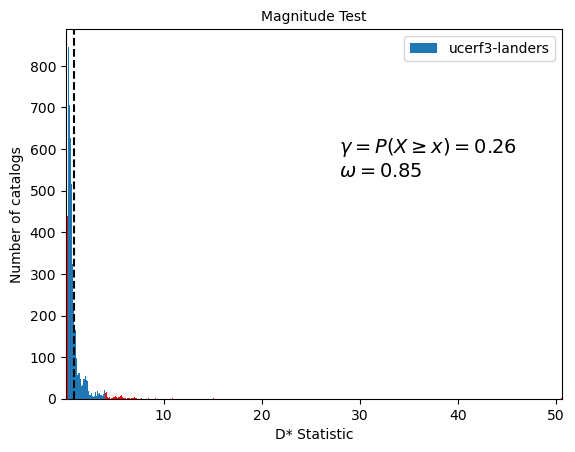

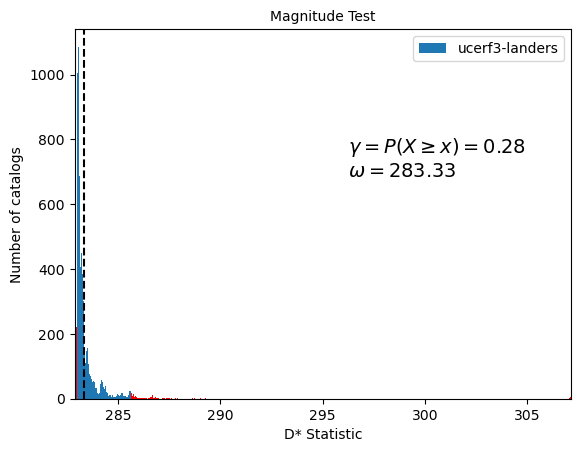

<Axes: title={'center': 'Magnitude Test'}, xlabel='D* Statistic', ylabel='Number of catalogs'>

In [24]:
mtest_chisquared = Chisquared_magnitude_test(forecast, comcat_catalog, seed=10, verbose = False)
mtest_chisquared.plot(show = True)


mtest_chisquared = Chisquared_p1_magnitude_test(forecast, comcat_catalog, seed=10, verbose = False)
mtest_chisquared.plot(show = True)